In [1]:
import os
import numpy as np
import onnxruntime as rt
import onnx
import matplotlib.pyplot as plt
from train.dataloader import CommaDataset, BatchDataLoader, BackgroundGenerator
from torch.utils.data import DataLoader
import cv2
import time
from utils import Calibration, draw_path, FULL_FRAME_SIZE, create_img_plot_canvas
from matplotlib.patches import Patch


In [2]:
plot_img_height, plot_img_width = 480, 640 # can be reduced for wandb

In [3]:
def seperate_points_and_std_values(path):
    points_indices = np.arange(0, path.shape[-1], 2)
    std_indices = np.arange(1, path.shape[-1], 2)

    points = path[:, points_indices]
    std_values = path[:, std_indices]

    return points, std_values


def extract_preds(res):
    # N is batch_size

    plan_start_idx = 0
    plan_end_idx = 4955

    lanes_start_idx = plan_end_idx
    lanes_end_idx = lanes_start_idx + 528

    lane_lines_prob_start_idx = lanes_end_idx
    lane_lines_prob_end_idx = lane_lines_prob_start_idx + 8

    road_start_idx = lane_lines_prob_end_idx
    road_end_idx = road_start_idx + 264
    #paths
    plan = res[:, plan_start_idx:plan_end_idx]  # (N, 4955)
    
    paths = np.array(np.split(plan, 5, axis=1)).reshape(-1, 5, 991)  # (N, 5, 991)
    path_probs = paths[:, :, -1]  # (N, 5)
    paths = paths[:, :, :-1].reshape(-1, 5, 2, 33, 15)  # (N, 5, 2, 33, 15)

    best_idx = np.argmax(path_probs, axis=1)[0]  # (N,)
    best_path = paths[:, best_idx, ...]  # (N, 2, 33, 15)
    
    #lanes
    lanes = res[:, lanes_start_idx:lanes_end_idx] # (N, 528)
    mean_outer_left = lanes[:, 0:66]
    mean_inner_left = lanes[:, 66:132]    
    mean_inner_right = lanes[:, 132:198]
    mean_outer_right = lanes[:, 198:264]

    # road_edges
    lane_road = res[:, road_start_idx:road_end_idx]
    mean_roadedg_right = lane_road[:, 0:66]
    mean_roadedg_left = lane_road[:, 66:132]

    

    ##TODO: parse road edges  and visualize them too.
    lanelines = [mean_outer_left, mean_inner_left, mean_inner_right, mean_outer_right]
    road_edges = [mean_roadedg_right,mean_roadedg_left]

    return lanelines, best_path, road_edges

In [4]:
real_preds = np.load('/home/nikita/data/2021-09-14--09-19-21/25/xyz_preds.npz')
real_paths_xyz = np.stack((real_preds['x'], real_preds['y'], real_preds['z']), axis=-1)
real_paths_xyz.shape

(1200, 33, 3)

#### Extract `seq_len`-th input_frame and bgr_frame from video:

In [5]:
comma_recordings_basedir = '/home/nikita/data'
path_to_onnx_model = 'train/supercombo.onnx'
os.makedirs('outs', exist_ok=True)

train_split = 0.8
seq_len = 6
single_frame_batches = False
prefetch_factor = 1
batch_size = 1
num_workers = 1

train_dataset = CommaDataset(comma_recordings_basedir, train_split=train_split, seq_len=seq_len,
                                shuffle=True, single_frame_batches=single_frame_batches, seed=42)
train_loader = DataLoader(train_dataset, batch_size=None, num_workers=num_workers, shuffle=False,
                        prefetch_factor=prefetch_factor, persistent_workers=True, collate_fn=None)
train_loader = BatchDataLoader(train_loader, batch_size=batch_size)
# train_loader = BackgroundGenerator(train_loader) # removed only for this example, keep in production

for it, batch in enumerate(train_loader):
    stacked_frames, plans, plans_probs, segment_finished, sequence_finished, bgr_frames = batch
    
    if it ==20:
        print(it)
        for t_idx in range(seq_len):
            
            input_frame = stacked_frames[0:1, t_idx, ...].numpy().astype(np.float32)
            bgr_frame = bgr_frames[0, t_idx, ...].numpy()

        break

print(input_frame.shape)



Using cached paths to videos and GTs...
Total # segments 72
Subset # segments: 58
20
(1, 12, 128, 256)


/home/gautam/openpilot-pipeline/utils.py:182: RuntimeWarning: divide by zero encountered in true_divide
  return (kep[:-1, :] / kep[-1, :]).T


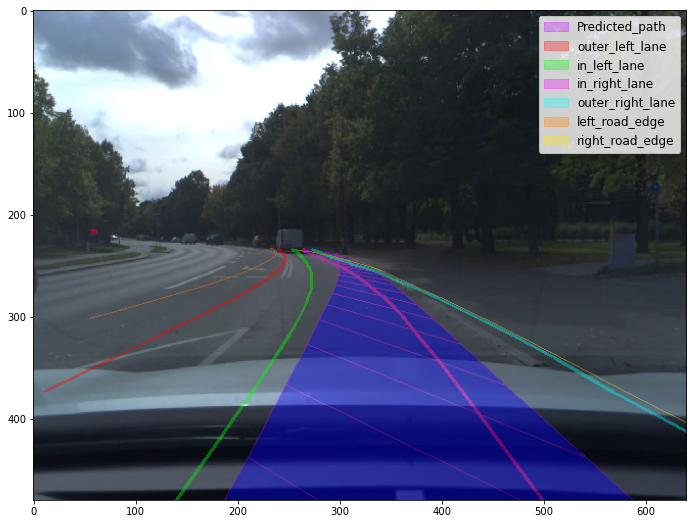

In [7]:
fill_color_gt = [0,  255, 0]
line_color_gt = [255,255, 0]
fill_color_preds = [0,  0,255]
line_color_preds = [200,0,255]
laneline_colors = [(255,0,0),(0,255,0),(255,0,255),(0,255,255)]
legend_laneline_colors = [[255,0,0],[0,255,0],[255,0,255],[0,255,255]]
legend_roadedge_colors = [[255,128,0],[255,234,0]]
X_IDXS = [
         0.    ,   0.1875,   0.75  ,   1.6875,   3.    ,   4.6875,
         6.75  ,   9.1875,  12.    ,  15.1875,  18.75  ,  22.6875,
        27.    ,  31.6875,  36.75  ,  42.1875,  48.    ,  54.1875,
        60.75  ,  67.6875,  75.    ,  82.6875,  90.75  ,  99.1875,
       108.    , 117.1875, 126.75  , 136.6875, 147.    , 157.6875,
       168.75  , 180.1875, 192.]

def legend_color(color, opacity=0.3):
    return np.append(np.array(color)/255, opacity)

model = onnx.load(path_to_onnx_model)

input_names = [node.name for node in model.graph.input]
output_names = [node.name for node in model.graph.output]

providers = ['CPUExecutionProvider']
onnxruntime_model = rt.InferenceSession(path_to_onnx_model, providers=providers)

recurrent_state = np.zeros((1, 512), dtype=np.float32)

inputs = {
    'input_imgs': input_frame,
    'desire': np.zeros((1, 8), dtype=np.float32),
    'traffic_convention': np.array([0, 1], dtype=np.float32).reshape(1, 2),
    'initial_state': recurrent_state,
}

outs = onnxruntime_model.run(output_names, inputs)[0]
lanelines, best_path, roadedges = extract_preds(outs)  # TODO: visualize these lanelines as well

# print(lanelines[0].shape)
# plot predictions
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

rpy_calib_gt = [0.00018335809, 0.034165092, -0.014245722]  # real calibration values during this ride
rpy_calib_pred = [0, 0, 0]  # calibration we currently use for pre-processing

calibration_gt = Calibration(rpy_calib_gt, plot_img_width=plot_img_width, plot_img_height=plot_img_height)
calibration_pred = Calibration(rpy_calib_pred, plot_img_width=plot_img_width, plot_img_height=plot_img_height)

# path_xyz_gt = real_paths_xyz[t_idx]
path_xyz_pred = best_path[0, 0, :, :3]

img_plot = create_img_plot_canvas(rgb_frame, calibration_gt) # calibration here doesn't really matter, just has to have the right plot_img_width and plot_img_height for correct scaling
# img_plot = draw_path(path_xyz_gt, img_plot, calibration_gt, fill_color=fill_color_gt, line_color=line_color_gt)
img_plot = draw_path(lanelines,roadedges, path_xyz_pred, img_plot, calibration_pred, X_IDXS, laneline_colors, fill_color=fill_color_preds, line_color=line_color_preds)

plot_width = 12
plot_height = plot_width * (FULL_FRAME_SIZE[1] / FULL_FRAME_SIZE[0])
plt.figure(figsize=(plot_width, plot_height))

plt.imshow(img_plot)

legend_elements = [#Patch(facecolor=legend_color(fill_color_gt), edgecolor=legend_color(line_color_gt),label='Ground Truth'),
                   Patch(facecolor=legend_color(line_color_preds), edgecolor=legend_color(line_color_preds),
                         label='Predicted_path'),
                         Patch(facecolor=legend_color(laneline_colors[0]), edgecolor=legend_color(laneline_colors[0]),
                         label='outer_left_lane'),
                         Patch(facecolor=legend_color(laneline_colors[1]), edgecolor=legend_color(laneline_colors[1]),
                         label='in_left_lane'),
                         Patch(facecolor=legend_color(laneline_colors[2]), edgecolor=legend_color(laneline_colors[2]),
                         label='in_right_lane'),
                         Patch(facecolor=legend_color(laneline_colors[3]), edgecolor=legend_color(laneline_colors[3]),
                         label='outer_right_lane'),
                         Patch(facecolor=legend_color(legend_roadedge_colors[0]), edgecolor=legend_color(legend_roadedge_colors[0]),
                         label='left_road_edge'),
                         Patch(facecolor=legend_color(legend_roadedge_colors[1]), edgecolor=legend_color(legend_roadedge_colors[1]),
                         label='right_road_edge')
                         
                         ]

plt.legend(handles=legend_elements, loc='upper right', prop={'size': 12})
plt.show()